In [2]:
#IMPORTS

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sn

In [112]:
#LOAD DATA
X = pd.read_csv('..\data\interim\X.csv',index_col=0)
y = pd.read_csv('..\data\interim\y.csv',index_col=0)

X_train = pd.read_csv('..\data\processed\X_train.csv',index_col=0)
X_test = pd.read_csv('..\data\processed\X_test.csv',index_col=0)

y_train = pd.read_csv('..\data\processed\y_train.csv',index_col=0)
y_test = pd.read_csv('..\data\processed\y_test.csv',index_col=0)

y_train = y_train.to_numpy().ravel()

In [4]:
#fitted model
max_depth = 20
min_samples_split = 5
min_samples_leaf = 1
max_features = 'sqrt'
random_state = 42
model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features, random_state=42)


n_estimators = 90
max_samples = 0.95
max_features = 1.0

modelDT = BaggingRegressor(estimator=model, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, random_state=42).fit(X_train, y_train)

y_pred_DT = modelDT.predict(X_test)
X_trainKNN = X_train/X_train.max()


X_testKNN = X_test/X_test.max()

knn = KNeighborsRegressor(n_neighbors=2)
modelKNN = BaggingRegressor(estimator=knn, n_estimators=30, max_features=0.55, random_state=42).fit(X_trainKNN,y_train)

y_pred_KNN = modelKNN.predict(X_testKNN)

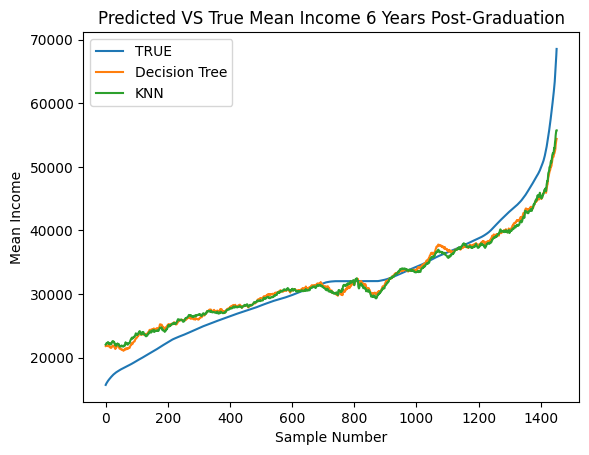

In [6]:

d = {'TRUE' : y_test.to_numpy().ravel(), 'Decision Tree' : y_pred_DT, 'KNN' : y_pred_KNN}
df = pd.DataFrame(d)
df = df.sort_values(by='TRUE')

true_rolling = df['TRUE'].rolling(50).mean()
pred_rolling_DT = df['Decision Tree'].rolling(50).mean()
pred_rolling_KNN = df['KNN'].rolling(50).mean()

d = {"TRUE" : true_rolling, "Decision Tree" : pred_rolling_DT, 'KNN' : pred_rolling_KNN}
df_roll = pd.DataFrame(d).dropna().reset_index(drop = True)

ax = df_roll.plot.line()

ax.set_title("Predicted VS True Mean Income 6 Years Post-Graduation")
ax.set_xlabel('Sample Number')
ax.set_ylabel('Mean Income')
plt.show()


In [97]:
#table for different intervals and the prediction accuracy
'''df = pd.DataFrame(columns=['Model', '< 10,000', '< 8,000', '< 5,000', '< 2,000'])

diff = np.absolute(y_test.to_numpy().ravel() - y_pred_DT.ravel())
diff_10000 = np.count_nonzero(diff < 10000)
print(diff_10000)
print(y_test.shape[0])
acc = diff_10000 / y_test.shape[0]

new_row = pd.Series({'Model':"Decision Tree", '< 10,000' : acc, '< 8,000' : 0.5, '< 5,000' : 0.4, '< 2,000' : 0.2})
df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

new_row = pd.Series({'Model':"KNN", '< 10,000' : 0.8, '< 8,000' : 0.55, '< 5,000' : 0.45, '< 2,000' : 0.25})
df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

new_row = pd.Series({'Model':"Lasso", '< 10,000' : 0.7, '< 8,000' : 0.4, '< 5,000' : 0.3, '< 2,000' : 0.2})
df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

#df = df.pivot(columns = 'Model', values = ['< 10,000', '< 8,000', '< 5,000', '< 2,000'])'''


df = pd.DataFrame({"Interval" : ['< 10,000', '< 8,000', '< 5,000', '< 2,000']})

new_row = pd.DataFrame({"Decision Tree" : [ 0.9, 0.5,0.4, 0.2]})
df = df.join(new_row)

new_row = pd.DataFrame({"KNN" : [ 0.95, 0.55,0.45, 0.25]})
df = df.join(new_row)

new_row = pd.DataFrame({"Lasso" : [ 0.6, 0.5,0.4, 0.3]})
df = df.join(new_row)

display(df)



,Interval,Decision Tree,KNN,Lasso
0,"< 10,000",0.9,0.95,0.6
1,"< 8,000",0.5,0.55,0.5
2,"< 5,000",0.4,0.45,0.4
3,"< 2,000",0.2,0.25,0.3


<Axes: xlabel='Interval'>

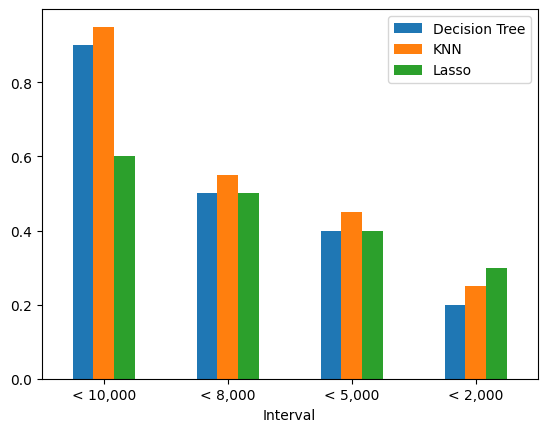

In [100]:
df.plot(x = 'Interval', kind = 'bar', stacked = False, rot = 0)

In [60]:
diff = np.absolute(y_test.to_numpy() - y_pred_DT)

In [163]:
y

,MN_EARN_WNE_P6
0,28400.0
1,39400.0
2,35400.0
3,40300.0
4,24400.0
...,...
4998,27000.0
4999,42700.0
5000,42700.0
5001,24100.0


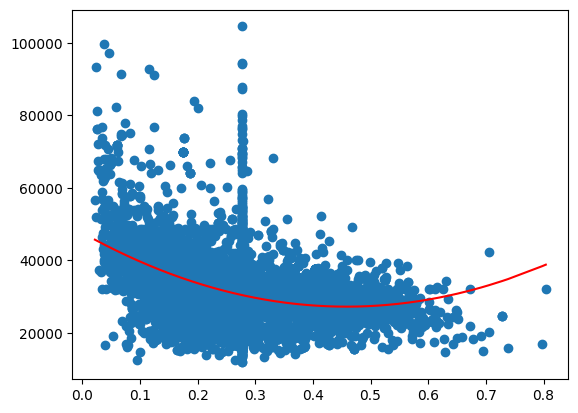

In [113]:
#Correlation with select featues to outcome
features = ['UGDS','UGDS_WHITE','COMP_ORIG_YR2_RT','WDRAW_ORIG_YR2_RT','RPY_1YR_RT','DEBT_MDN', 'MEDIAN_HH_INC','POVERTY_RATE','UNEMP_RATE','UGDS_MEN','UGDS_WOMEN']

keep = ['COMP_ORIG_YR4_RT','WDRAW_ORIG_YR4_RT', 'RPY_1YR_RT', 'DEBT_MDN', 'MEDIAN_HH_INC', 'POVERTY_RATE','UNEMP_RATE']

feature = 'WDRAW_ORIG_YR4_RT'
d = {"Income" : y.to_numpy().ravel(), 'Feature' : X[feature] }
df = pd.DataFrame(d).sort_values(by = 'Feature').reset_index(drop = True)
#display(df)

fit = np.polyfit(df['Feature'], df['Income'], 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(df['Feature']) + b * df['Feature'] + c

plt.scatter(x = df['Feature'], y = df['Income'])
plt.plot(df['Feature'], fit_equation, color = 'red') 
plt.show()

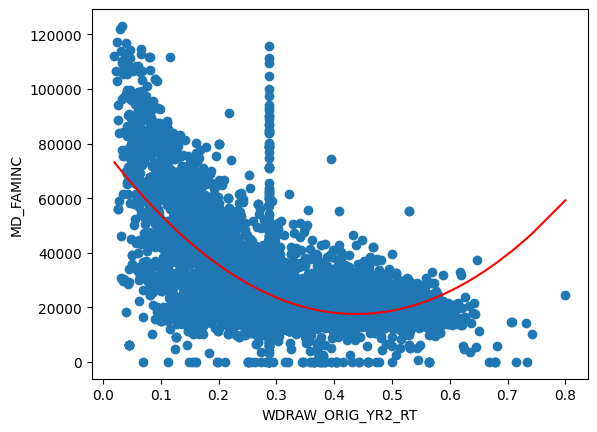

In [172]:
#comparing completion rate to withdrawal rate
#display(df)
x_feature = 'WDRAW_ORIG_YR2_RT'
y_feature = 'MD_FAMINC'

''' 
#how family income can effect withdrawal from school
x_feature = 'WDRAW_ORIG_YR2_RT'
y_feature = 'MD_FAMINC'

x_feature = 'COMP_ORIG_YR4_RT'
y_feature = 'MD_FAMINC'

#how school tution revenue can affect completion rate at a school
x_feature = 'COMP_ORIG_YR4_RT'
y_feature = 'TUITFTE'

#shows that a big part of predicting
x_feature = 'FAMINC'
y_feature = 'MN_EARN_WNE_P6'

'''

df = X.join(y)

d = {x_feature : df[x_feature], y_feature : df[y_feature] }
df = pd.DataFrame(d).sort_values(by = x_feature)
#display(df)

fit = np.polyfit(df[x_feature], df[y_feature], 2)
a = fit[0]
b = fit[1]
c = fit[2]
fit_equation = a * np.square(df[x_feature]) + b * df[x_feature] + c

plt.scatter(x = df[x_feature], y = df[y_feature])

plt.plot(df[x_feature], fit_equation, color = 'red')
plt.xlabel(x_feature)
plt.ylabel(y_feature) 

plt.show()


In [168]:
#feature correlation matrix

df = X.join(y)
corr = df.corr()


top5 = corr['MN_EARN_WNE_P6'].sort_values().tail(10)
bottom5 = corr['MN_EARN_WNE_P6'].sort_values().head(10)

display(top5)

'''cor_matrix = corr.abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)'''

COMPL_RPY_3YR_RT     0.584945
NONCOM_RPY_3YR_RT    0.585003
NONCOM_RPY_5YR_RT    0.588792
RPY_1YR_RT           0.593285
MD_FAMINC            0.597796
RPY_3YR_RT           0.620811
FAMINC               0.628626
RPY_5YR_RT           0.642495
RPY_7YR_RT           0.651727
MN_EARN_WNE_P6       1.000000
Name: MN_EARN_WNE_P6, dtype: float64

'cor_matrix = corr.abs()\n\nupper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))\n\nto_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]\nprint(); print(to_drop)'

In [11]:
df = pd.DataFrame(columns = ['Feature 1', 'Feature 2', 'Correlation'])

for col in upper_tri.columns:
    max_id = upper_tri[col].idxmax()
    max_value = upper_tri[col].max()
    new_row = pd.Series({'Feature 1': col, 'Feature 2': max_id, 'Correlation' : max_value})
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

df = df.sort_values(by = 'Correlation', ascending = False)

In [12]:
''' 
 POVERTY_RATE      MEDIAN_HH_INC    0.727436
54     WDRAW_DEBT_MDN      GRAD_DEBT_MDN    0.726281
'''

display(corr['POVERTY_RATE']['MEDIAN_HH_INC'])

-0.7274357498010857

In [13]:
''' 
visualization ideas:
- table comparing metrics (DONE)
- table comparing accuracy of each model at certain thresholds (DONE)
-correlation of a select feature and the outcome (DONE)
-compare predicted value to the actual value of each model (DONE)
'''

' \nvisualization ideas:\n- table comparing metrics\n- table comparing accuracy of each model at certain thresholds\n- something to do with features and their importance\n- maybe some type of distribution plot\n-correlation of a select feature and the outcome (DONE)\n-compare predicted value to the actual value of each model (DONE)\n-correlation matrix\n\nhttps://jfmaloon.medium.com/visualizing-multivariate-regression-2344a0b5e270\n\n'

In [23]:
test1 = pd.Series([1,2,3,4],name = 'Target')
df = pd.DataFrame(test1)

test2 = pd.Series([5,6,7,8], name = 'Features')

df = pd.concat([df,test2], axis = 1)


display(df)

,Target,Features
0,1,5
1,2,6
2,3,7
3,4,8


In [27]:
target_row = pd.Series(y_test.to_numpy().ravel(), name = "TRUE").rolling(50).mean()
data = pd.DataFrame(target_row)

In [28]:
display(data)

,TRUE
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1496,33319.409246
1497,33481.409246
1498,33285.409246
1499,33345.409246
